In [1]:
import tropycal.tracks as tracks
from useful_functions import create_genesis_grid_labels
import numpy as np
import xarray as xr
from scipy.ndimage import gaussian_filter
from scipy.ndimage import gaussian_filter1d
from scipy.ndimage import median_filter
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
#import skimage.measure as ms
import scipy.ndimage as nd
from itertools import product
import copy

In [2]:
# # Time ranges for EVERYTHING desired
month_range = np.arange(1,13,1).astype(float)
test_years = np.arange(2005,2021,1).astype(float)
train_years = np.arange(1950,2005,1).astype(float)
# train_years = np.setdiff1d(train_years, np.arange(1971,1979,1))
Latitude=np.arange(0,80,2).astype(float)
Longitude=np.arange(260,360,2).astype(float)

In [3]:
# # Grab ibtracs data (uncomment this section if you want to recreate genesis (observed) labels, otherwise it is already saved)
# basin_dataset = tracks.TrackDataset(basin='north_atlantic',source='ibtracs',include_btk=True)

# # Create genesis labels from ibtracs data (slowest step)
# vmin=0
# print('Training Dataset')
# train_labels_predropped = create_genesis_grid_labels(month_range,train_years,vmin,basin_dataset)
# print('Testing Dataset')
# test_labels_predropped = create_genesis_grid_labels(month_range,test_years,vmin,basin_dataset)

# train_labels_predropped.unstack().to_dataset(name='data').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
# test_labels_predropped.unstack().to_dataset(name='data').to_netcdf("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")

In [4]:
# Read in Data

train_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/train_labels_predropped.nc")
train_labels_predropped = train_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

test_labels_predropped_read = xr.open_dataset("/glade/work/acheung/Initial_RF_Datasets/test_labels_predropped.nc")
test_labels_predropped = test_labels_predropped_read.stack(z=("Month","Latitude","Longitude","Year"))

In [5]:
train_labels_predropped_read

<xarray.Dataset>
Dimensions:                        (Year: 55, Longitude: 50, Latitude: 40, Month: 12)
Coordinates:
  * Year                           (Year) float64 1.95e+03 ... 2.004e+03
  * Longitude                      (Longitude) float64 260.0 262.0 ... 358.0
  * Latitude                       (Latitude) float64 0.0 2.0 4.0 ... 76.0 78.0
  * Month                          (Month) float64 1.0 2.0 3.0 ... 11.0 12.0
Data variables:
    __xarray_dataarray_variable__  (Month, Latitude, Longitude, Year) int32 0...

In [6]:
train_labels_predropped_read.rename({'__xarray_dataarray_variable__':'data'})

<xarray.Dataset>
Dimensions:    (Year: 55, Longitude: 50, Latitude: 40, Month: 12)
Coordinates:
  * Year       (Year) float64 1.95e+03 1.951e+03 ... 2.003e+03 2.004e+03
  * Longitude  (Longitude) float64 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * Latitude   (Latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0
  * Month      (Month) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0
Data variables:
    data       (Month, Latitude, Longitude, Year) int32 0 0 0 0 0 ... 0 0 0 0 0

In [7]:
# Deep copy the dataset so it is not referencing
train_canes_use = copy.deepcopy(train_labels_predropped_read["__xarray_dataarray_variable__"]).astype(float)

In [8]:
# Temporal smoothing
for i, j in product(range(train_canes_use.shape[1]),range(train_canes_use.shape[2])): # Loop over each grid cell
    stacked_grid = train_canes_use[:,i,j,:].stack(z=("Year", "Month")).astype(float) # Stack all times for a single grid cell
    temporally_filtered_grid = gaussian_filter(stacked_grid,sigma=1.5) # Filter a single grid cell over time
    unstacked_smoothed_grid = xr.DataArray(temporally_filtered_grid,coords=stacked_grid.coords).unstack() # Put filtered data into XR
    # Assign smoothed grid cell data to training data array
    train_canes_use[:,i,j,:] = copy.deepcopy(unstacked_smoothed_grid.transpose()) # Deep copy the unstacked so that it is not referencing

In [9]:
# Spatial smoothing    
spatially_filtered_grid = [] # List to store the array of each month
stack_for_spatial = train_canes_use.stack(z=("Year", "Month")) # Stack for easier looping

for spatial_iter in range(stack_for_spatial.shape[2]): # Loop 2D array over all times
    spatially_filtered_grid_indiv = gaussian_filter(stack_for_spatial[:,:,spatial_iter],sigma=1.5) # Filter the 2D array spatially
    spatially_filtered_grid.append(spatially_filtered_grid_indiv) # Save 2D array to list

In [10]:
# Convert from list to XR
spatially_temporally_filtered_XR = xr.DataArray(
    spatially_filtered_grid,
    coords = [stack_for_spatial.coords['z'],
              stack_for_spatial.coords['Latitude'],
              stack_for_spatial.coords['Longitude']]
).unstack()

In [11]:
spatially_temporally_filtered_XR

<xarray.DataArray (Latitude: 40, Longitude: 50, Year: 55, Month: 12)>
array([[[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
...
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],

        [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         ...,
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
          0.00000000e+00, 0.00000000e+00, 0.00000000e+00]]]])
Coordinates:
  * Latitude   (Latitude) float64 0.0 2.0 4.0 6.0 8.0 ... 72.0 74.0 76.0 78.0
  * Longitude  (Longitude) float64 260.0 262.0 264.0 266.0 ... 354.0 356.0 358.0
  * Year       (Year) float64 1.95e+03 1.951e+03 ... 2.003e+03 2.004e+03
  * Month      (Month) float64 1.0 2.0 3.0 4.0 5.0 ... 8.0 9.0 10.0 11.0 12.0

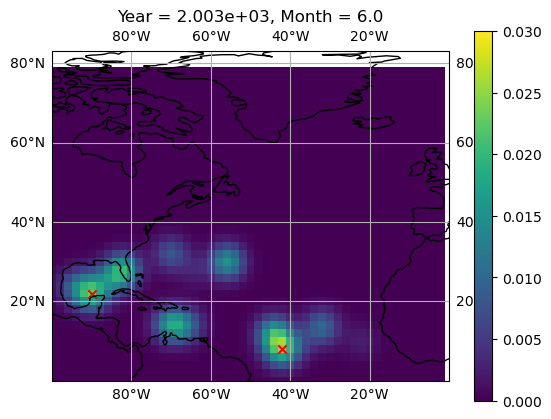

In [12]:
mo_val=6
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

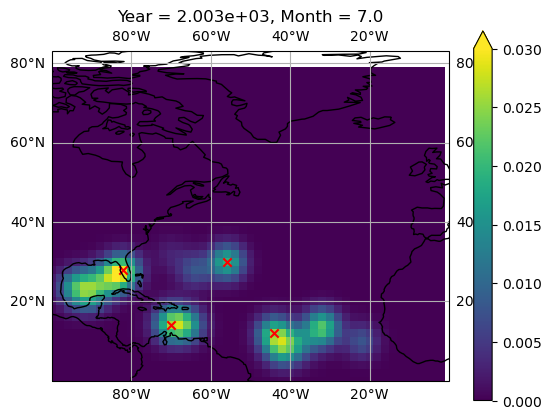

In [13]:
mo_val=7
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

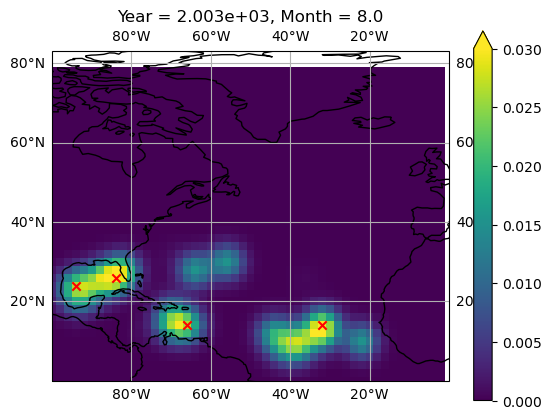

In [14]:
mo_val=8
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

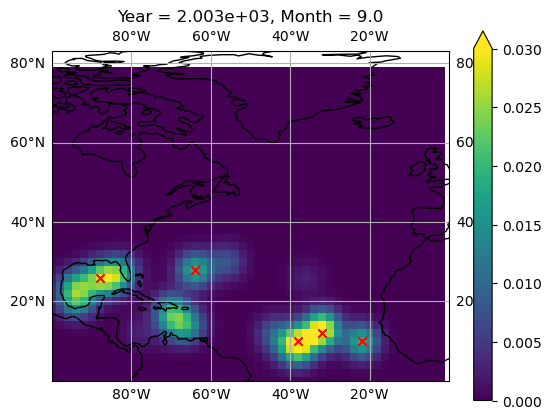

In [15]:
mo_val=9
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

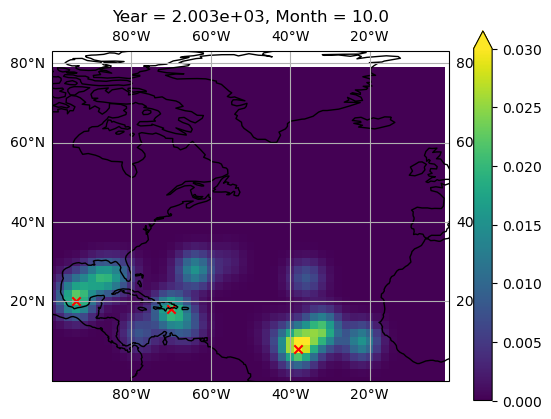

In [16]:
mo_val=10
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

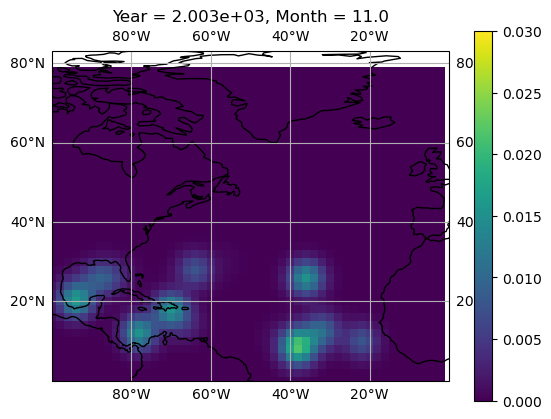

In [17]:
mo_val=11
yr_val=2003

# Plot temporally then spatially filtered data
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
spatially_temporally_filtered_XR.sel(Month=mo_val,Year=yr_val).plot(vmin=0,vmax=0.03)
### scatter
tmp_scat = train_labels_predropped_read["__xarray_dataarray_variable__"].sel(Month=mo_val,Year=yr_val).stack(
    new=['Latitude','Longitude'])
tmp_scat = tmp_scat.where(tmp_scat>0,drop=True)
ax.scatter(tmp_scat['Longitude'],tmp_scat['Latitude'],marker='x',color='r')
###
#plt.savefig("Spatial_Temporal_Filtered.png",dpi=600)
plt.show()

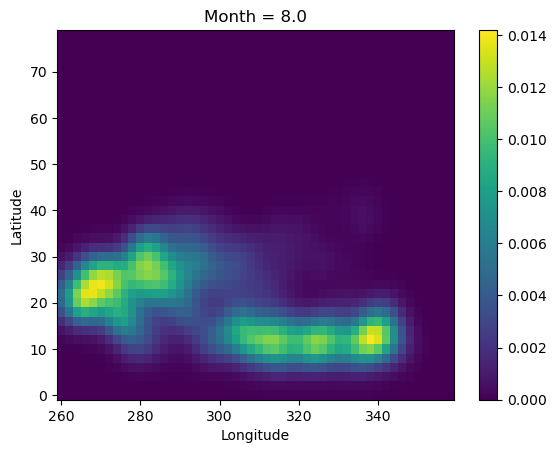

In [23]:
spatially_temporally_filtered_XR.groupby('Month').mean('Year').sel(Month=8).plot()

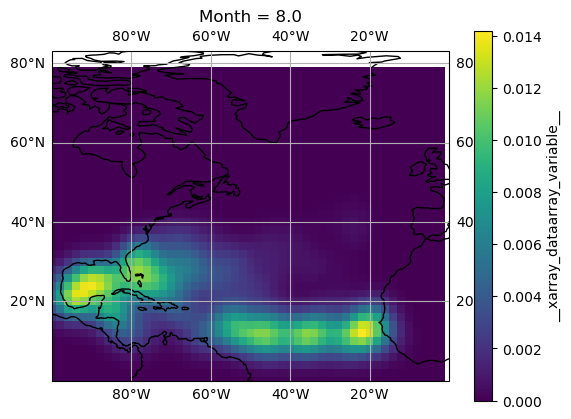

In [25]:
num_years = len(train_labels_predropped_read["Year"]) # Number of Years

# Sum by month, across all years
sum_canes = train_labels_predropped_read.groupby("Month").sum("Year", skipna=True).astype(float)
three_sum_canes = xr.concat([sum_canes,sum_canes,sum_canes],dim="Month").astype(float)

Gauss_SmoothAN = three_sum_canes["__xarray_dataarray_variable__"]/num_years
# Temporal Smoothing
for i, j in product(range(len(Gauss_SmoothAN[0,:,0])),range(len(Gauss_SmoothAN[0,0,:]))): # Loop over all grid cells
    Gauss_SmoothAN[:,i,j] = gaussian_filter(Gauss_SmoothAN[:,i,j], sigma=1.5) # temporal filter

sliced_gauss = Gauss_SmoothAN[len(sum_canes["__xarray_dataarray_variable__"][:,0,0]):
                              len(sum_canes["__xarray_dataarray_variable__"][:,0,0])*2,:,:] # Take only desired section (middle)

# Spatial Smoothing
for loop in range(sliced_gauss.shape[0]):
    sliced_gauss[loop,:,:] = gaussian_filter(sliced_gauss[loop,:,:].astype(float),sigma=1.5) # spatial filter

# Plot climo data of specified month
plt.figure()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ax.coastlines()
ax.gridlines(draw_labels=True)
ax.set_extent([-100, 0, 0, 80])
sliced_gauss.sel(Month=8).plot()
#plt.savefig('climo_double_smoothed.png',dpi=600)
plt.show()